In [16]:
# open files in generations/
import pandas as pd
import os
import re

In [17]:
# open files in generations directory
def open_files(directory):
    files = os.listdir(directory)
    files.sort()
    return files

In [18]:
files = open_files('generations-new')

models_generations = {}
for file in files:
    model = model = re.sub(r"^fine-tuned-|-decoding-\d+.csv", "", file)
    gen = re.search(r"decoding-\d+", file).group()
    print(model, gen)
    if model == 'baseline':
        continue

    if model not in models_generations:
        models_generations[model] = {}
    if gen not in models_generations[model]:
        models_generations[model][gen] = {}

    models_generations[model][gen] = pd.read_csv('generations-new/' + file)

Ministral-8B-Instruct-2410 decoding-3


In [23]:
models_generations['Ministral-8B-Instruct-2410']['decoding-3']

,id,input,prediction,rhetorical_figure,explanation,expected_output,raw_generation
0,test_132,"Gli amici di Rouhani, per il suo compleanno, g...",The sentence contains a proposition that fails...,OTHER,expresses situational irony,The sentence expresses situational irony. That...,"<s> [INST] Given the ironic sentence (INPUT), ..."
1,test_20,dei privati che finanziano le scuole statali n...,The sentence asks a question in order to make ...,ANALOGY,involves similarity between two things that ha...,The sentence involves similarity between two t...,"<s> [INST] Given the ironic sentence (INPUT), ..."
2,test_82,Ma perchè scegliere Mario Monti quando ci sare...,The sentence asks a question in order to make ...,RHETORICAL QUESTION,asks a question in order to make a point rathe...,The sentence asks a question in order to make ...,"<s> [INST] Given the ironic sentence (INPUT), ..."
3,test_97,la cosa bella del governo Monti è che ha acces...,The sentence expresses situational irony. That...,EX:OXYMORON PARADOX,presents a contradiction that is explicit,The sentence presents a contradiction that is ...,"<s> [INST] Given the ironic sentence (INPUT), ..."
4,test_57,Chi è entrato nel cellulare di Jennifer Lawren...,The sentence presents a contradiction that is ...,EX:CONTEXT SHIFT,shows a sudden change of the topic,The sentence shows a sudden change of the topi...,"<s> [INST] Given the ironic sentence (INPUT), ..."
...,...,...,...,...,...,...,...
137,test_72,"Agnese Renzi tampona un camion. Urlando ""Matte...",The sentence presents a contradiction that is ...,IM:FALSE ASSERTION,contains a proposition that fails to make sens...,The sentence contains a proposition that fails...,"<s> [INST] Given the ironic sentence (INPUT), ..."
138,test_107,@user Leggo che lei è Ministro della PUBBLICA ...,The sentence asks a question in order to make ...,EX:OXYMORON PARADOX,presents a contradiction that is explicit,The sentence presents a contradiction that is ...,"<s> [INST] Given the ironic sentence (INPUT), ..."
139,test_15,"Se può perdonare una madre imperfetta, perdone...",The sentence involves similarity between two t...,ANALOGY,involves similarity between two things that ha...,The sentence involves similarity between two t...,"<s> [INST] Given the ironic sentence (INPUT), ..."
140,test_93,"Facciamo che ""Il Papa prega per la pace"" lo di...",The sentence asks a question in order to make ...,RHETORICAL QUESTION,asks a question in order to make a point rathe...,The sentence asks a question in order to make ...,"<s> [INST] Given the ironic sentence (INPUT), ..."


In [30]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

Ministral-8B-Instruct-2410
                     precision    recall  f1-score   support

RHETORICAL QUESTION     0.6786    0.8636    0.7600        22
          HYPERBOLE     0.4286    0.3750    0.4000         8
              OTHER     0.2414    0.3500    0.2857        20
            ANALOGY     0.6250    0.5769    0.6000        26
          EUPHEMISM     0.0000    0.0000    0.0000         8
 IM:FALSE ASSERTION     0.2222    0.1667    0.1905        12
   EX:CONTEXT SHIFT     0.2000    0.1667    0.1818        18
EX:OXYMORON PARADOX     0.3600    0.3214    0.3396        28

           accuracy                         0.4085       142
          macro avg     0.3445    0.3525    0.3447       142
       weighted avg     0.3928    0.4085    0.3965       142

Confusion Matrix:
                     RHETORICAL QUESTION  HYPERBOLE  OTHER  ANALOGY  \
RHETORICAL QUESTION                   19          0      0        0   
HYPERBOLE                              0          3      5        0   
OTHER  

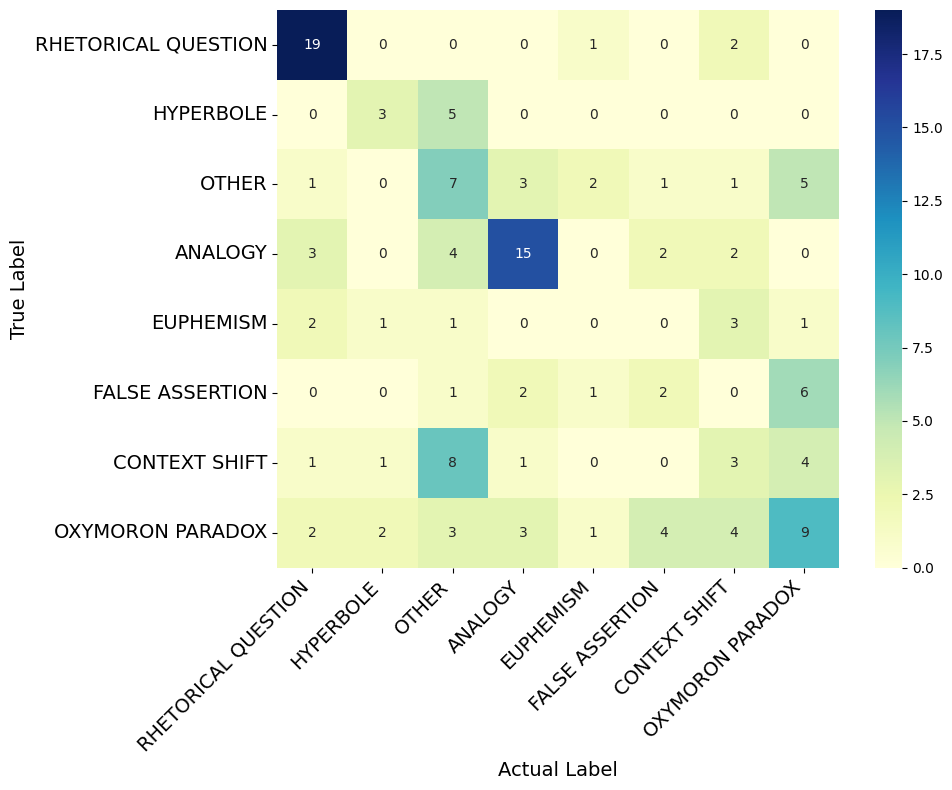

In [31]:
labels = [
    'RHETORICAL QUESTION',
    'HYPERBOLE',
    'OTHER',
    'ANALOGY',
    'EUPHEMISM',
    'IM:FALSE ASSERTION',
    'EX:CONTEXT SHIFT',
    'EX:OXYMORON PARADOX'
]

label_map = {
    'QUESTION': 'RHETORICAL QUESTION',
    'ASSERTION': 'IM:FALSE ASSERTION',
    'SHIFT': 'EX:CONTEXT SHIFT',
    'PARADOX': 'EX:OXYMORON PARADOX'
}

predictions = set()

for model in models_generations:
    print(model)
    df = models_generations[model]['decoding-3']
        
    y_true = df['rhetorical_figure']
    y_pred = df['prediction']

    # Estrai l’ultima parola dalla predizione
    y_pred = y_pred.apply(lambda x: x.split()[-1] if isinstance(x, str) else x)
    y_pred = y_pred.str.replace('.', '', regex=False)

    # Mappa le abbreviazioni in etichette complete
    y_pred = y_pred.map(label_map).fillna(y_pred)

    predictions.update(y_pred.unique())

    report = classification_report(y_true, y_pred, labels=labels, digits=4, zero_division=0.0)
    print(report)

    # Rinomina etichette per chiarezza
    label_rename_map = {
        'IM:FALSE ASSERTION': 'FALSE ASSERTION',
        'EX:CONTEXT SHIFT': 'CONTEXT SHIFT',
        'EX:OXYMORON PARADOX': 'OXYMORON PARADOX'
    }

    renamed_labels = [label_rename_map.get(label, label) for label in labels]

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_df = pd.DataFrame(cm, index=renamed_labels, columns=renamed_labels)

    print("Confusion Matrix:")
    print(cm_df)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='YlGnBu', cbar=True,
                xticklabels=renamed_labels, yticklabels=renamed_labels)
    plt.xlabel("Actual Label", fontsize=14)
    plt.ylabel("True Label", fontsize=14)
    plt.xticks(rotation=45, ha='right', fontsize=14)
    plt.yticks(rotation=0, fontsize=14)
    plt.tight_layout()

    # salva svg
    plt.savefig(f'confusion-matrix-ministral-cot-ft.svg', format="svg")

    plt.show()
